In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import yfinance as yf
from pathlib import Path
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import quantstats as qs

/Users/gw/workspace/quant-studies/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
%matplotlib inline
qs.extend_pandas()

In [4]:
symbols = Path("data/multi-symbols.csv").read_text().split("\n")

In [5]:
start_date, end_train_date, end_date = "2019-01-01", "2021-12-31", "2023-12-31"

In [6]:
df = yf.download(symbols, start=start_date, end=end_date)["Adj Close"]

[*********************100%%**********************]  30 of 30 completed


In [7]:
df.dropna(axis=1, inplace=True, how="all")
df.dropna(inplace=True)
df.sort_index(inplace=True)

In [8]:
df_train = df.loc[start_date:end_train_date]
df_test = df.loc[end_train_date:end_date]

In [9]:
df_returns = pd.DataFrame(df_train.pct_change().mean()*252, columns=["Returns"])
df_returns["Volatility"] = df_train.pct_change().std()*np.sqrt(252)

In [10]:
df_returns.head()

Returns  Volatility
ABEV3.SA   0.082625    0.360441
B3SA3.SA   0.199732    0.444739
BBAS3.SA  -0.026027    0.445210
BOVA11.SA  0.096495    0.307751
BRL=X      0.153119    0.184350

In [11]:
px.scatter(df_returns, x="Volatility", y="Returns", hover_name=df_returns.index)

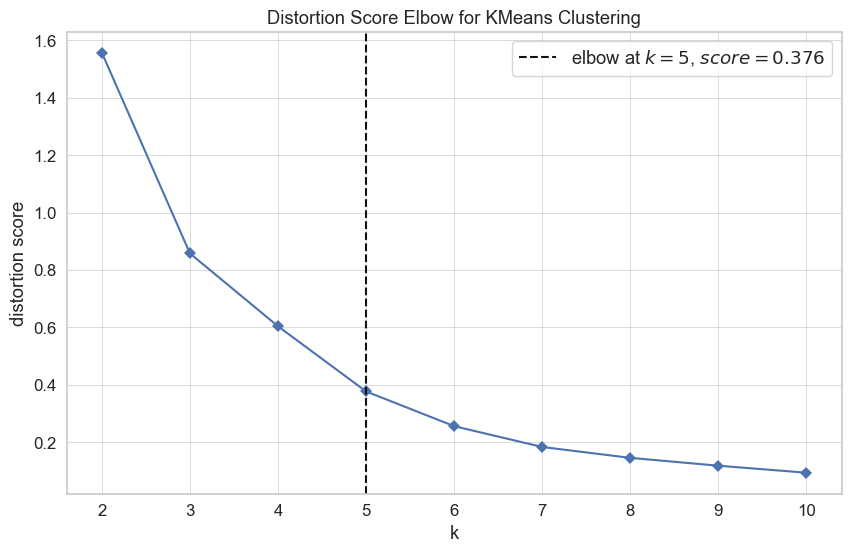

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
yellowbrick.style.rcmod.set_style(style="whitegrid")

elbow_vis = KElbowVisualizer(KMeans(n_init=10), k=10, timings=False)
elbow_vis.fit(df_returns.copy())
elbow_vis.show()

In [13]:
k = elbow_vis.elbow_value_
model = KMeans(n_clusters = k, random_state = 42, n_init=10)

In [14]:
df_clustered = df_returns.copy()
df_clustered['Cluster'] = model.fit_predict(df_returns.values)

In [15]:
df_clustered["Cluster"] = df_clustered["Cluster"].astype(str)
df_clustered = df_clustered.sort_values(by="Cluster")

fig = px.scatter(df_clustered,
                 x="Volatility", y="Returns", color="Cluster",
                 title="Return x Volatility")
fig.update_traces(marker_size=15)
fig.show()

In [16]:
benchmark = yf.download("^BVSP", start=start_date, end=end_date)["Adj Close"].pct_change()

[*********************100%%**********************]  1 of 1 completed


In [17]:
returns_by_cluster = []
for cluster in df_clustered["Cluster"].unique():
    tickers = df_clustered[df_clustered["Cluster"] == cluster].index.to_list()
    print(f"{cluster = }, {tickers = }")    
    returns_by_cluster.append(df[tickers].pct_change().mean(axis=1).dropna())

cluster = '0', tickers = ['ETH-USD', 'BTC-USD']
cluster = '1', tickers = ['SBSP3.SA', 'PETR4.SA', 'EQTL3.SA', 'LEVE3.SA', 'CMIG4.SA', 'KLBN11.SA', 'SUZB3.SA', 'VALE3.SA', 'B3SA3.SA', 'CCRO3.SA']
cluster = '2', tickers = ['POMO4.SA', 'UGPA3.SA', 'MULT3.SA', 'LREN3.SA', 'ABEV3.SA', 'ITSA4.SA', 'ITUB4.SA', 'BBAS3.SA']
cluster = '3', tickers = ['JBSS3.SA', 'WEGE3.SA', 'CSNA3.SA', 'KEPL3.SA']
cluster = '4', tickers = ['GBPUSD=X', 'EURUSD=X', 'EGIE3.SA', 'BRL=X', 'BOVA11.SA', '^GSPC']


In [18]:
train_data, test_data = [], []
for i, returns in enumerate(returns_by_cluster):
    train_data.append((returns[:end_train_date], f"Cluster {i}"))    
    test_data.append((returns[end_train_date:end_date], f"Cluster {i}"))

train_data.append((benchmark[:end_train_date], "Benchmark"))
test_data.append((benchmark[end_train_date:end_date], "Benchmark"))

In [19]:
def plot_portfolio(portfolio, history_name):
    fig = px.line()

    for returns, name in portfolio:
        fig.add_scatter(x=returns.index, y=returns.cumsum()*100, mode='lines', name=name)
            
    fig.update_layout(title=f'Portfolio Simulation - {history_name} History',
                          xaxis_title='Date',
                          yaxis_title='Cumulative Returns',
                          legend_title='Tickers')
    
    fig.show()

In [20]:
plot_portfolio(test_data, "Train")

[*********************100%%**********************]  1 of 1 completed


/Users/gw/workspace/quant-studies/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/Users/gw/workspace/quant-studies/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/Users/gw/workspace/quant-studies/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-01-04   2019-01-04
End Period                 2023-12-28   2023-12-28
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          46.55%       161.93%
CAGR﹪                     5.44%        14.27%

Sharpe                     0.44         0.93
Prob. Sharpe Ratio         82.53%       97.44%
Smart Sharpe               0.38         0.81
Sortino                    0.59         1.29
Smart Sortino              0.51         1.12
Sortino/√2                 0.42         0.91
Smart Sortino/√2           0.36         0.79
Omega                      1.19         1.19

Max Drawdown               -46.82%      -44.09%
Longest DD Days            919          307
Volatility (ann.)          26.82%       25.33%
R^2                        0.87         0.87
Information Ratio          0.08         0.08
Calmar            

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-01-24  2020-03-23  2020-11-25   307    -44.091108        -39.683251
2  2022-04-04  2022-07-15  2022-08-16   135    -15.197778        -14.928710
3  2021-06-08  2021-11-04  2022-03-02   268    -13.549210        -12.733181
4  2023-01-26  2023-03-23  2023-05-10   105    -11.583578        -10.826549
5  2021-01-11  2021-03-01  2021-04-07    87    -11.361965        -10.780804

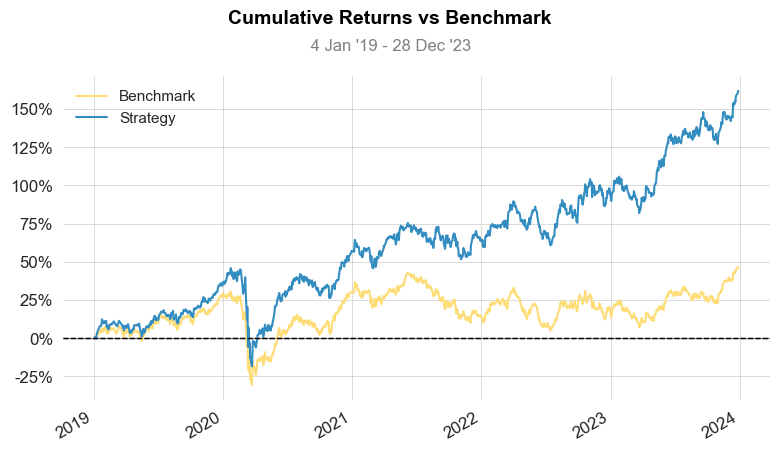

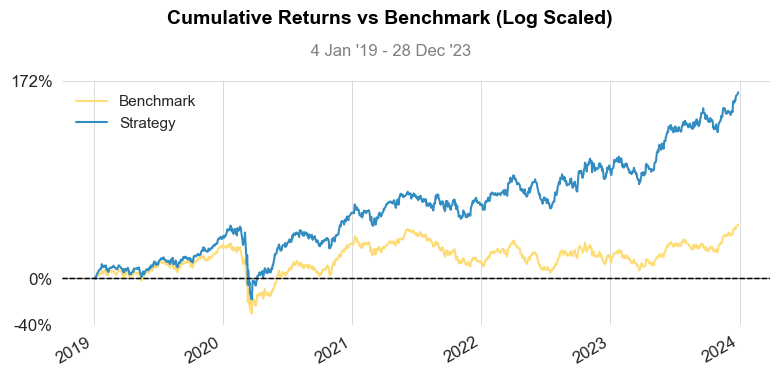

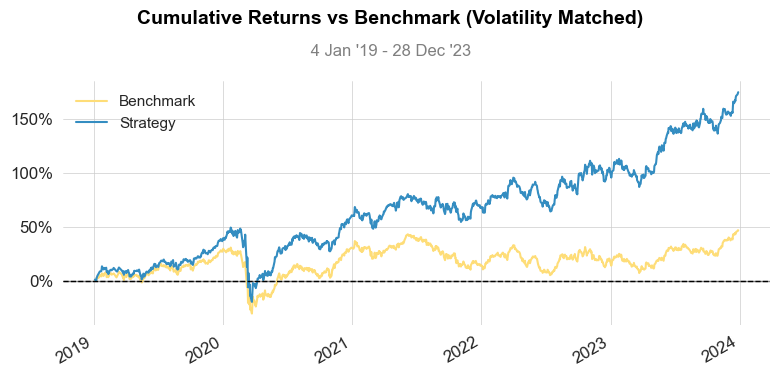

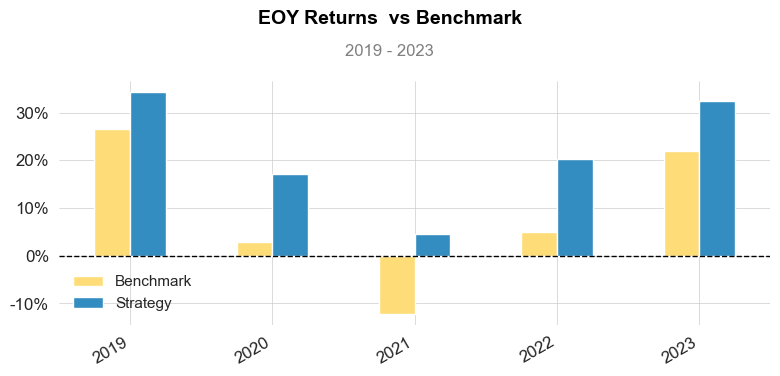

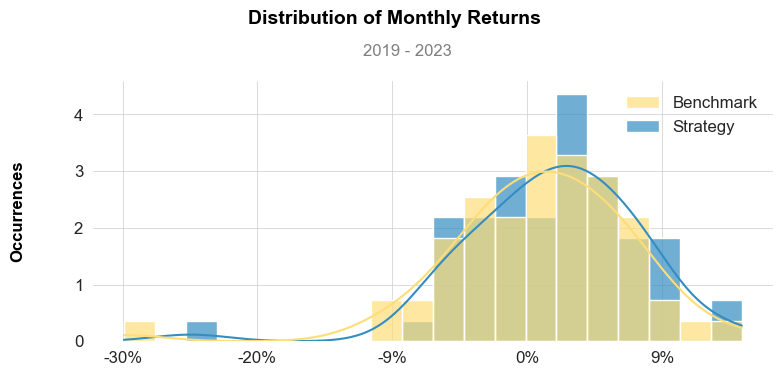

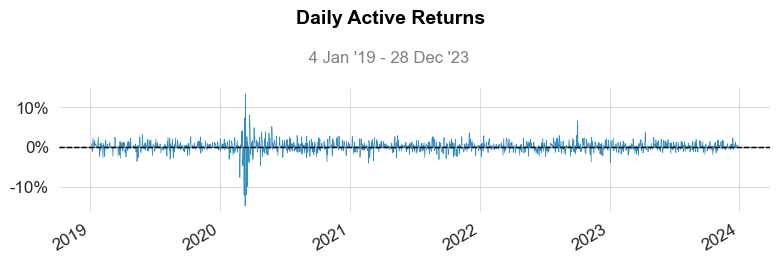

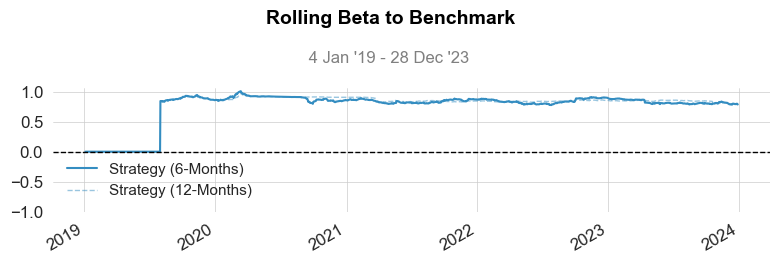

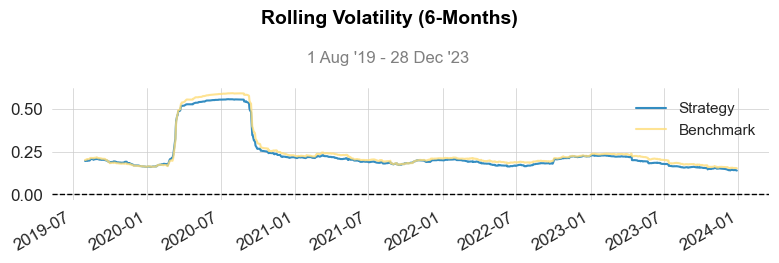

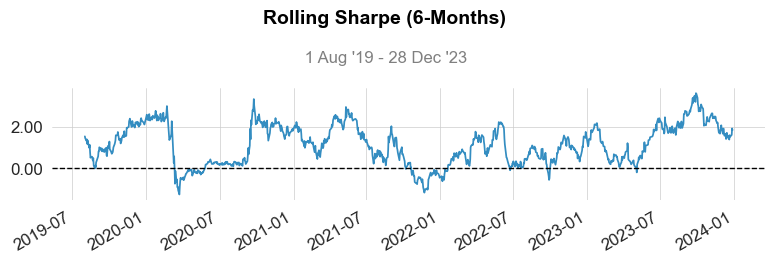

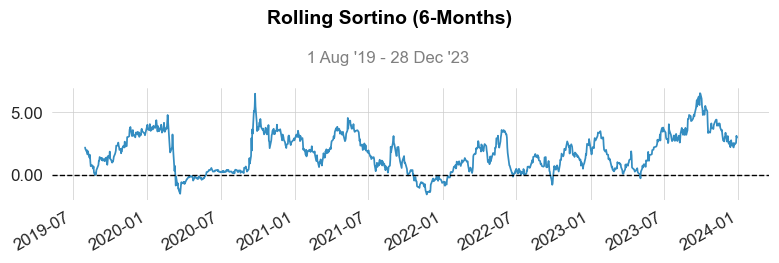

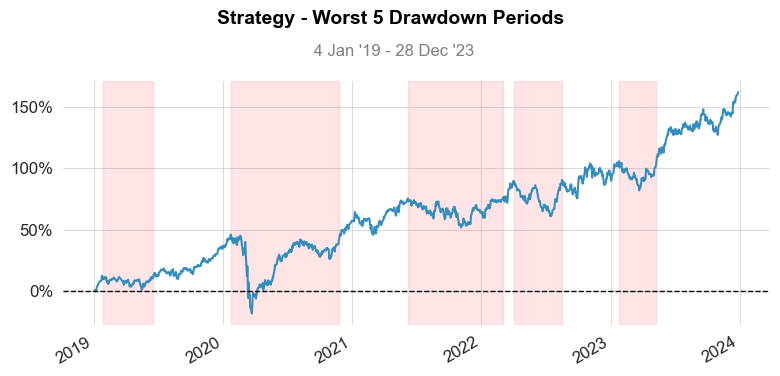

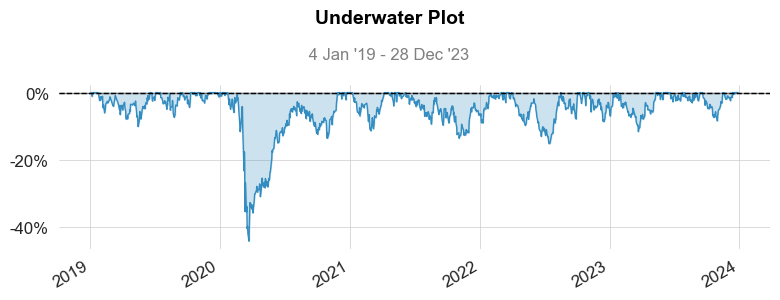

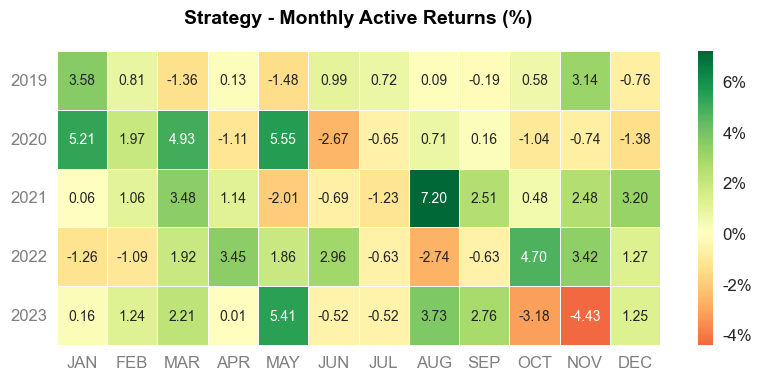

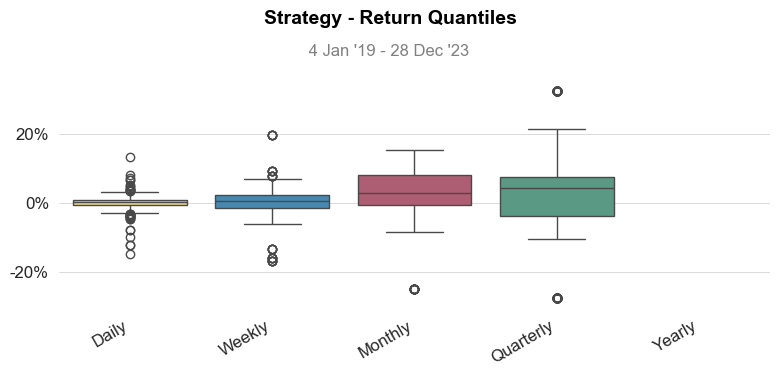

In [21]:
cluster_1 = returns_by_cluster[1]
qs.reports.full(cluster_1, "^BVSP")

In [29]:
cluster_1_tickers = df_clustered[df_clustered["Cluster"] == "1"].index.to_list()
print(f"{cluster_1_tickers = }")
Path("data/outputs/kmeans-portfolio.csv").write_text("\n".join(cluster_1_tickers))

cluster_1_tickers = ['SBSP3.SA', 'PETR4.SA', 'EQTL3.SA', 'LEVE3.SA', 'CMIG4.SA', 'KLBN11.SA', 'SUZB3.SA', 'VALE3.SA', 'B3SA3.SA', 'CCRO3.SA']


90